In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import graphviz
import time
import os

# Sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Tensorflow/Keras
import tensorflow as tf

# Load Data

In [2]:
# Load data
train_df = pd.read_csv("../processed_data/train_df.csv")
train_df['DATE_TIME']= pd.to_datetime(train_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# These were exported to train_df.csv
train_df["HOUR"] = train_df['DATE_TIME'].dt.hour
train_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv("../processed_data/test_df.csv")
test_df['DATE_TIME']= pd.to_datetime(test_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

#These were exported to test_df.csv
test_df["HOUR"] = test_df['DATE_TIME'].dt.hour
test_df.dropna(inplace=True)
test_df.reset_index(drop=True, inplace=True)

mae_results = {}
rmse_results = {}

test_df=test_df.dropna()
train_df=train_df.dropna()


In [3]:
test_df

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,WEATHER_SOURCE,DATE,TIME,is_daytime,yesterday_max_daily_yield,HOUR
0,2020-06-12 02:30:00,4136001,LYwnQax7tkwH5Cb,0.000000,0.000000,3718.000000,1.795083e+09,22.610987,22.146187,0.000000,iq8k7ZNt4Mwm3w0,2020-06-12,02:30:00,0,3718.0,2
1,2020-06-12 23:45:00,4136001,xoJJ8DcxJEcupym,0.000000,0.000000,4788.000000,2.093055e+08,23.099230,22.757666,0.000000,iq8k7ZNt4Mwm3w0,2020-06-12,23:45:00,0,3971.0,23
2,2020-06-12 07:45:00,4136001,WcxssY2VbP4hApt,267.833333,262.780000,194.800000,1.818769e+08,24.554531,27.705916,0.175870,iq8k7ZNt4Mwm3w0,2020-06-12,07:45:00,1,3947.0,7
3,2020-06-12 07:45:00,4136001,mqwcsP2rE7J0TFp,284.813333,279.646667,201.533333,5.937824e+08,24.554531,27.705916,0.175870,iq8k7ZNt4Mwm3w0,2020-06-12,07:45:00,1,3877.0,7
4,2020-06-12 07:45:00,4136001,oZ35aAeoifZaQzV,262.600000,257.593333,195.866667,1.660165e+09,24.554531,27.705916,0.175870,iq8k7ZNt4Mwm3w0,2020-06-12,07:45:00,1,5585.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23183,2020-06-17 16:15:00,4135001,bvBOhCH3iADSZry,341.128571,334.957143,5215.000000,6.538764e+06,24.112787,28.996932,0.235078,HmiyD2TTLFNqkNe,2020-06-17,16:15:00,1,5757.0,16
23184,2020-06-17 16:15:00,4135001,iCRJl6heRkivqQ3,351.928571,345.714286,5693.571429,7.426000e+06,24.112787,28.996932,0.235078,HmiyD2TTLFNqkNe,2020-06-17,16:15:00,1,6305.0,16
23185,2020-06-17 16:15:00,4135001,ih0vzX44oOqAx2f,350.714286,344.485714,5497.857143,6.425869e+06,24.112787,28.996932,0.235078,HmiyD2TTLFNqkNe,2020-06-17,16:15:00,1,6124.0,16
23186,2020-06-17 16:15:00,4135001,rGa61gmuvPhdLxV,360.528571,353.985714,5688.428571,7.356635e+06,24.112787,28.996932,0.235078,HmiyD2TTLFNqkNe,2020-06-17,16:15:00,1,6243.0,16


#### Function that scaled DC_POWER of plant 1 down by 10. New values were exported to train_df.csv and test_df.csv.

In [4]:
# def scale_down_plant_1(df):
#     for i in df.index:
#         if(df.iloc[i].PLANT_ID == 4135001):
#             df.loc[i,'DC_POWER'] = df.iloc[i].DC_POWER/10
            
# scale_down_plant_1(train_df)
# scale_down_plant_1(test_df)

# train_df.to_csv("../processed_data/train_df.csv", index=False)
# test_df.to_csv("../processed_data/test_df.csv", index=False)

In [5]:
def calculate_metrics(label, true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae_results[label] = mae
    rmse_results[label] = rmse
    print(label + " MAE: " + str(mae) + " kW.")
    print(label + " RMSE: " + str(rmse) + " kW.")
    
def plot_true_vs_pred(label, true, pred):
    x_ax = range(len(true))
    plt.plot(x_ax, true, label="original")
    plt.plot(x_ax, pred, label="predicted")
    plt.title("Test and Predicted Data " + label)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

# Baseline Predictor

#### Baseline predictor predicts the average train AC power for everything.

In [6]:
baseline_train_y = train_df.AC_POWER
baseline_test_y = test_df.AC_POWER

baseline = baseline_train_y.mean()
calculate_metrics("Baseline", baseline_test_y, [baseline]*len(baseline_test_y))

Baseline MAE: 293.85475863244017 kW.
Baseline RMSE: 336.7762729048805 kW.


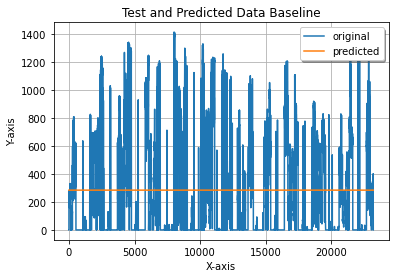

In [7]:
plot_true_vs_pred("Baseline", baseline_test_y, [baseline]*len(baseline_test_y))

# Linear Regression 1

#### Linear regression predictor. Grid search cross validation.

#### Set features and targets

In [8]:
train_df['IRR_HOUR']=train_df['IRRADIATION']*train_df['HOUR']
train_df['IRR_AMBTEMP']=train_df['IRRADIATION']*train_df['AMBIENT_TEMPERATURE']

train_df['IRR_YDAYYIELD']=train_df['IRRADIATION']*train_df['yesterday_max_daily_yield']
test_df['IRR_HOUR']=test_df['IRRADIATION']*test_df['HOUR']
test_df['IRR_AMBTEMP']=test_df['IRRADIATION']*test_df['AMBIENT_TEMPERATURE']
test_df['IRR_YDAYYIELD']=test_df['IRRADIATION']*test_df['yesterday_max_daily_yield']


In [9]:
# 'TIME' performs better than 'HOUR' in this case
lr_features = ["PLANT_ID", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME"]

# Train data
lr_train_x = train_df[lr_features]
lr_train_y = train_df.AC_POWER

lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
lr_train_x = pd.get_dummies(lr_train_x)

# Standardize data
stdn = preprocessing.StandardScaler()
stdn.fit(lr_train_x)
lr_train_x = stdn.transform(lr_train_x)


# Test data
lr_test_x = test_df[lr_features]
lr_test_y = test_df.AC_POWER

lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")
lr_test_x = pd.get_dummies(lr_test_x)

# Standardize data
lr_test_x = stdn.transform(lr_test_x)

/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
lr1_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr_1.fit(lr_train_x, lr_train_y)

print("Linear regression parameters: ", lr_1.best_params_)

Linear regression parameters:  {'copy_X': True, 'fit_intercept': True}


In [11]:
lr_1_preds = lr_1.predict(lr_test_x)
calculate_metrics("Linear Regression 1", lr_test_y, lr_1_preds)

Linear Regression 1 MAE: 75.4230478989228 kW.
Linear Regression 1 RMSE: 140.53501216706024 kW.


In [12]:
coefs = lr_1.best_estimator_.coef_
coefs

array([-3.50904423e+01,  1.30601680e+02,  2.03208466e+02,  4.70805846e+12,
        4.70805846e+12, -3.99022665e+11, -3.99022665e+11, -3.99022665e+11,
       -3.96629661e+11, -3.94964116e+11, -3.94964116e+11, -3.95334869e+11,
       -3.94964116e+11, -3.98655485e+11, -3.99022665e+11, -3.99022665e+11,
       -3.99022665e+11, -3.99022665e+11, -3.99022665e+11, -3.99022665e+11,
       -3.99022665e+11, -3.99022665e+11, -3.99022665e+11, -3.99022665e+11,
       -3.99022665e+11, -3.99022665e+11, -3.94964116e+11, -3.91610894e+11,
       -3.90861666e+11, -3.92731946e+11, -3.99022665e+11, -3.99022665e+11,
       -4.03038640e+11, -4.03038640e+11, -4.03038640e+11, -4.03038640e+11,
       -4.07013300e+11, -4.07013300e+11, -4.07013300e+11, -4.07013300e+11,
       -4.07013300e+11, -4.07013300e+11, -4.07013300e+11, -4.07013300e+11,
       -4.07013300e+11, -4.07013300e+11, -4.07013300e+11, -4.07013300e+11,
       -4.07013300e+11, -4.07013300e+11, -4.07013300e+11, -4.07013300e+11,
       -4.03038640e+11, -

In [13]:
lr_test_x

array([[-1.10115322, -0.84156231, -0.76200453, ..., -0.10168867,
        -0.10168867, -0.10168867],
       [-0.98045703, -0.79213975, -0.76200453, ..., -0.10168867,
        -0.10168867,  9.83393714],
       [-0.62069918, -0.39219906, -0.20702024, ..., -0.10168867,
        -0.10168867, -0.10168867],
       ...,
       [-0.72990057, -0.2878531 , -0.0201811 , ..., -0.10168867,
        -0.10168867, -0.10168867],
       [-0.72990057, -0.2878531 , -0.0201811 , ..., -0.10168867,
        -0.10168867, -0.10168867],
       [-0.95483657, -0.8100633 , -0.76200453, ..., -0.10168867,
        -0.10168867,  9.83393714]])

In [14]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(lr_1, lr_train_x,
                                                            np.array(lr_train_y), lr_test_x,
                                                            np.array(lr_test_y),
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)

NameError: name 'bias_variance_decomp' is not defined

In [122]:
avg_bias

22668.866458365897

In [123]:
avg_var

17.741258470081135

## Linear Regression 1: Adding Yday AC


In [15]:
# 'TIME' performs better than 'HOUR' in this case
lr_features = ["PLANT_ID", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME", "AC_POWER_daybefore"]

# Train data
lr_train_x = train_df[lr_features]
lr_train_y = train_df.AC_POWER

lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
lr_train_x = pd.get_dummies(lr_train_x)

# Standardize data
stdn = preprocessing.StandardScaler()
stdn.fit(lr_train_x)
lr_train_x = stdn.transform(lr_train_x)


# Test data
lr_test_x = test_df[lr_features]
lr_test_y = test_df.AC_POWER

lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")
lr_test_x = pd.get_dummies(lr_test_x)

# Standardize data
lr_test_x = stdn.transform(lr_test_x)

lr1_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr_1.fit(lr_train_x, lr_train_y)

print("Linear regression parameters: ", lr_1.best_params_)

KeyError: "['AC_POWER_daybefore'] not in index"

In [261]:
lr_1_preds = lr_1.predict(lr_test_x)
calculate_metrics("Linear Regression 1", lr_test_y, lr_1_preds)

Linear Regression 1 MAE: 76.64278383531972 kW.
Linear Regression 1 RMSE: 144.52695898923068 kW.


## Linear Regression 1: Adding Yday AC + Yday Daily Yield

In [262]:
# 'TIME' performs better than 'HOUR' in this case
lr_features = ["PLANT_ID", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME", "AC_POWER_daybefore", 'yesterday_max_daily_yield']

# Train data
lr_train_x = train_df[lr_features]
lr_train_y = train_df.AC_POWER

lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
lr_train_x = pd.get_dummies(lr_train_x)

# Standardize data
stdn = preprocessing.StandardScaler()
stdn.fit(lr_train_x)
lr_train_x = stdn.transform(lr_train_x)


# Test data
lr_test_x = test_df[lr_features]
lr_test_y = test_df.AC_POWER

lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")
lr_test_x = pd.get_dummies(lr_test_x)

# Standardize data
lr_test_x = stdn.transform(lr_test_x)

lr1_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr_1.fit(lr_train_x, lr_train_y)

print("Linear regression parameters: ", lr_1.best_params_)

/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/3817483365.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/3817483365.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")


Linear regression parameters:  {'copy_X': True, 'fit_intercept': True}


In [263]:
lr_1_preds = lr_1.predict(lr_test_x)
calculate_metrics("Linear Regression 1", lr_test_y, lr_1_preds)

Linear Regression 1 MAE: 77.6624043846961 kW.
Linear Regression 1 RMSE: 144.5895097633838 kW.


## Linear Regression 1: Adding Interactions


In [268]:
# 'TIME' performs better than 'HOUR' in this case
lr_features = ["PLANT_ID", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME", "AC_POWER_daybefore", "yesterday_max_daily_yield", "IRR_YDAYYIELD","IRR_HOUR"]

# Train data
lr_train_x = train_df[lr_features]
lr_train_y = train_df.AC_POWER

lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
lr_train_x = pd.get_dummies(lr_train_x)

# Standardize data
stdn = preprocessing.StandardScaler()
stdn.fit(lr_train_x)
lr_train_x = stdn.transform(lr_train_x)


# Test data
lr_test_x = test_df[lr_features]
lr_test_y = test_df.AC_POWER

lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")
lr_test_x = pd.get_dummies(lr_test_x)

# Standardize data
lr_test_x = stdn.transform(lr_test_x)

lr1_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr_1.fit(lr_train_x, lr_train_y)

print("Linear regression parameters: ", lr_1.best_params_)

/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/2790262864.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/2790262864.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")


Linear regression parameters:  {'copy_X': True, 'fit_intercept': True}


In [269]:
lr_1_preds = lr_1.predict(lr_test_x)
calculate_metrics("Linear Regression 1", lr_test_y, lr_1_preds)

Linear Regression 1 MAE: 73.05481896206646 kW.
Linear Regression 1 RMSE: 141.6799963911987 kW.


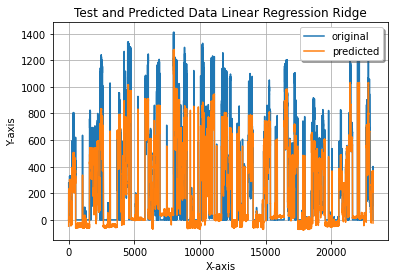

In [216]:
plot_true_vs_pred("Linear Regression Ridge", lr_test_y, lr_1_preds)

# Linear Regression 2 (Ridge)

#### Linear regression with ridge regularization. Grid search cross validation.

In [270]:
lr_reg_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

lr_2 = GridSearchCV(Ridge(), lr_reg_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_2.fit(lr_train_x, lr_train_y)

print("Linear regression 2 (Ridge) parameters: ", lr_2.best_params_)

Linear regression 2 (Ridge) parameters:  {'alpha': 1000}


In [271]:
lr_2_preds = lr_2.predict(lr_test_x)
calculate_metrics("Linear Regression Ridge", lr_test_y, lr_2_preds)

Linear Regression Ridge MAE: 73.8102873741319 kW.
Linear Regression Ridge RMSE: 141.5781501430189 kW.


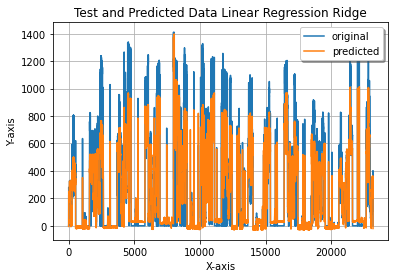

In [230]:
plot_true_vs_pred("Linear Regression Ridge", lr_test_y, lr_2_preds)

# Linear Regression 3 (Lasso)

#### Linear regression with lasso regularization. Grid search cross validation.

In [272]:
lr_3 = GridSearchCV(Lasso(), lr_reg_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_3.fit(lr_train_x, lr_train_y)

print("Linear regression 3 (Lasso) parameters: ", lr_3.best_params_)

/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+09, tolerance: 1.211e+06
  model = cd_fast.enet_coordinate_descent(
/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+09, tolerance: 1.211e+06
  model = cd_fast.enet_coordinate_descent(
/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

Linear regression 3 (Lasso) parameters:  {'alpha': 0.1}


In [273]:
lr_3_preds = lr_3.predict(lr_test_x)
calculate_metrics("Linear Regression Lasso", lr_test_y, lr_3_preds)

Linear Regression Lasso MAE: 73.55227742572319 kW.
Linear Regression Lasso RMSE: 141.96824312356603 kW.


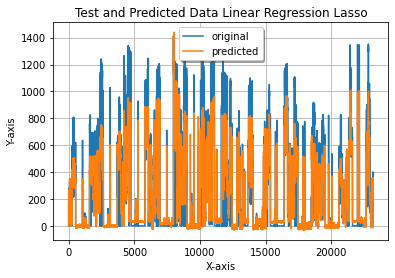

In [233]:
plot_true_vs_pred("Linear Regression Lasso", lr_test_y, lr_3_preds)

# Decision Tree 1

#### Decision tree predictor. Grid search cross validation on decision tree max depths 1-50. No need to standardize data for trees.

#### Set features and targets

In [293]:
# I found using 'HOUR' rather than 'TIME' results in higher accuracy in this case.
tree_1_features = ["PLANT_ID", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "HOUR"]

# Train data
tree_1_train_x = train_df[tree_1_features]
tree_1_train_y = train_df.AC_POWER

# One-hot-encode categories
tree_1_train_x.PLANT_ID = tree_1_train_x.PLANT_ID.astype("category")
tree_1_train_x.HOUR = tree_1_train_x.HOUR.astype("category")
tree_1_train_x = pd.get_dummies(tree_1_train_x)


# Test data
tree_1_test_x = test_df[tree_1_features]
tree_1_test_y = test_df.AC_POWER

# One-hot-encode categories
tree_1_test_x.PLANT_ID = tree_1_test_x.PLANT_ID.astype("category")
tree_1_test_x.HOUR = tree_1_test_x.HOUR.astype("category")


tree_1_test_x = pd.get_dummies(tree_1_test_x)

/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/2298886893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_1_train_x.PLANT_ID = tree_1_train_x.PLANT_ID.astype("category")
/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/2298886893.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_1_train_x.HOUR = tree_1_train_x.HOUR.astype("category")
/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_6043/2298886893.py:19: SettingWithCopyWarning: 
A value is trying to

In [296]:
dt_1_parameters = {'max_depth': range(1,50)}
dt_1 = GridSearchCV(DecisionTreeRegressor(random_state=100), 
                    dt_1_parameters, 
                    return_train_score=True,
                    verbose=3,
                    scoring='neg_mean_squared_error', 
                    n_jobs=-1)

dt_1.fit(tree_1_train_x, tree_1_train_y)
print("Optimal decision best parameters: ", dt_1.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Optimal decision best parameters:  {'max_depth': 5}


In [297]:
dt_1_preds = dt_1.predict(tree_1_test_x)
calculate_metrics("Decision Tree 1", tree_1_test_y, dt_1_preds)

Decision Tree 1 MAE: 47.13975714963662 kW.
Decision Tree 1 RMSE: 135.80264527870875 kW.


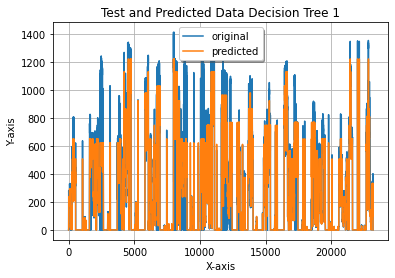

In [243]:
plot_true_vs_pred("Decision Tree 1", tree_1_test_y, dt_1_preds)

In [278]:
feature_importances = pd.Series(dt_1.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                  0.956970
PLANT_ID_4135001             0.030403
yesterday_max_daily_yield    0.009116
AMBIENT_TEMPERATURE          0.003044
AC_POWER_daybefore           0.000411
HOUR_7                       0.000056
HOUR_17                      0.000000
HOUR_13                      0.000000
HOUR_14                      0.000000
HOUR_15                      0.000000
HOUR_16                      0.000000
HOUR_19                      0.000000
HOUR_18                      0.000000
HOUR_11                      0.000000
HOUR_20                      0.000000
HOUR_21                      0.000000
HOUR_22                      0.000000
HOUR_12                      0.000000
HOUR_8                       0.000000
HOUR_10                      0.000000
HOUR_9                       0.000000
MODULE_TEMPERATURE           0.000000
HOUR_6                       0.000000
HOUR_5                       0.000000
HOUR_4                       0.000000
dtype: float64

In [22]:
dot_data = export_graphviz(dt_1.best_estimator_,
                          out_file=None,
                          feature_names=tree_1_train_x.columns,
                          proportion=True,
                          impurity=True,
                          filled=True,
                          rounded=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree_1_viz')

'decision_tree_1_viz.pdf'

<AxesSubplot:xlabel='depth'>

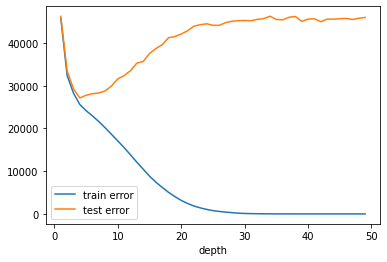

In [90]:
results = pd.DataFrame()
results['depth'] = dt_1_parameters['max_depth']
results['train error'] = 1 - dt_1.cv_results_['mean_train_score']
results['test error'] = 1 -  dt_1.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth', y='train error')
results.plot.line(x='depth', y='test error', ax=ax1)

# Random Forest

#### Radom forest predictor.

In [294]:
#rf_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 200, 5)}
#rf_params = {'max_depth': np.arange(5, 10, 5), 'n_estimators':np.arange(5, 10, 5)}
#rf_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 30, 5)}
rf_params = {'max_depth': np.arange(1, 14, 1), 'n_estimators':np.arange(1, 20, 1)}

rfCV = GridSearchCV(RandomForestRegressor(random_state=1), rf_params, 
                    return_train_score=True, 
                    scoring='neg_mean_squared_error', 
                    verbose=1, 
                    n_jobs=-1)

start = time.time()
rfCV.fit(tree_1_train_x, tree_1_train_y)
end = time.time()
print(str((end - start)/60) + " minutes to train random forest.")

print('Random Forest Regresor:')
print(' Optimal Parameters:', rfCV.best_params_)
print(' Optimal test R2:', rfCV.best_score_.round(3))

Fitting 5 folds for each of 247 candidates, totalling 1235 fits
5.397890988985697 minutes to train random forest.
Random Forest Regresor:
 Optimal Parameters: {'max_depth': 6, 'n_estimators': 2}
 Optimal test R2: -26930.151


In [295]:
rf_preds = rfCV.predict(tree_1_test_x)
calculate_metrics("Random Forest", tree_1_test_y, rf_preds)

Random Forest MAE: 46.74331158418726 kW.
Random Forest RMSE: 135.10482260707457 kW.


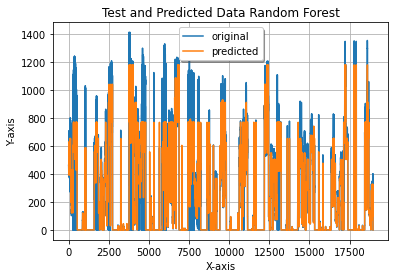

In [290]:
plot_true_vs_pred("Random Forest", tree_1_test_y, rf_preds)

In [103]:
feature_importances = pd.Series(rfCV.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                   9.006466e-01
IRR_YDAYYIELD                 6.589630e-02
PLANT_ID_4136001              1.247851e-02
yesterday_max_daily_yield     8.573316e-03
PLANT_ID_4135001              4.178878e-03
AMBIENT_TEMPERATURE           2.150274e-03
MODULE_TEMPERATURE            1.389797e-03
SOURCE_KEY_81aHJ1q11NBPMrL    1.050136e-03
SOURCE_KEY_Quc1TzYxW2pYoWX    6.169802e-04
SOURCE_KEY_vOuJvMaM2sgwLmb    5.060421e-04
IRR_AMBTEMP                   4.971918e-04
SOURCE_KEY_rrq4fwE8jgrTyWY    4.644699e-04
SOURCE_KEY_Mx2yZCDsyf6DPfv    4.371333e-04
SOURCE_KEY_V94E5Ben1TlhnDV    3.338325e-04
SOURCE_KEY_LYwnQax7tkwH5Cb    3.035783e-04
HOUR_7                        1.693138e-04
HOUR_9                        8.206313e-05
SOURCE_KEY_LlT2YUhhzqhg5Sw    6.344140e-05
SOURCE_KEY_Et9kgGMDl729KT4    5.957451e-05
HOUR_13                       4.546986e-05
SOURCE_KEY_oZZkBaNadn6DNKz    3.502321e-05
SOURCE_KEY_bvBOhCH3iADSZry    1.250403e-05
HOUR_14                       9.178111e-06
HOUR_16    

# Gradient Boosting Trees

#### Gradient boosting tree predictors.

In [291]:
#gb_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 200, 5)}
gb_params = {'max_depth': np.arange(5, 10, 5), 'n_estimators':np.arange(5, 10, 5)}
#gb_params = {'max_depth': np.arange(1, 12, 1), 'n_estimators':np.arange(1, 16, 1)}

gbtCV = GridSearchCV(GradientBoostingRegressor(learning_rate=0.56, random_state=1), gb_params, 
                     return_train_score=True, 
                     scoring='neg_mean_squared_error', 
                     verbose=1, 
                     n_jobs=-1)

start = time.time()
gbtCV.fit(tree_1_train_x, tree_1_train_y)
end = time.time()
print(str((end - start)/60) + " minutes to train gradient boosting trees.")

print('Random Forest Regresor:')
print(' Optimal Parameters:', gbtCV.best_params_)
print(' Optimal test R2:', gbtCV.best_score_.round(3))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.07458666563034058 minutes to train gradient boosting trees.
Random Forest Regresor:
 Optimal Parameters: {'max_depth': 5, 'n_estimators': 5}
 Optimal test R2: -27240.542


In [292]:
gbt_preds = gbtCV.predict(tree_1_test_x)
calculate_metrics("Gradient Boosting", tree_1_test_y, gbt_preds)

Gradient Boosting MAE: 48.3301186964847 kW.
Gradient Boosting RMSE: 131.35225126563665 kW.


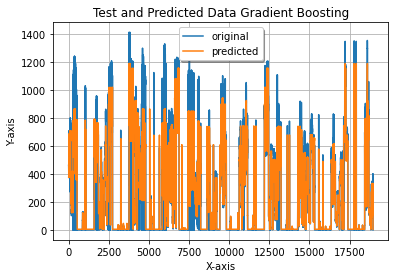

In [283]:
plot_true_vs_pred("Gradient Boosting", tree_1_test_y, gbt_preds)

In [284]:
feature_importances = pd.Series(rfCV.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                  0.956177
PLANT_ID_4135001             0.030827
yesterday_max_daily_yield    0.010326
AMBIENT_TEMPERATURE          0.002104
AC_POWER_daybefore           0.000485
HOUR_7                       0.000081
HOUR_17                      0.000000
HOUR_13                      0.000000
HOUR_14                      0.000000
HOUR_15                      0.000000
HOUR_16                      0.000000
HOUR_19                      0.000000
HOUR_18                      0.000000
HOUR_11                      0.000000
HOUR_20                      0.000000
HOUR_21                      0.000000
HOUR_22                      0.000000
HOUR_12                      0.000000
HOUR_8                       0.000000
HOUR_10                      0.000000
HOUR_9                       0.000000
MODULE_TEMPERATURE           0.000000
HOUR_6                       0.000000
HOUR_5                       0.000000
HOUR_4                       0.000000
dtype: float64

# Feed Forward Neural Network 1

#### FF neural network predictor.

In [6]:
def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()
    
def build_model(lr=0.0001):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

Metal device set to: Apple M1 Max
Epoch 1/20


2022-07-11 20:10:50.063293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 20:10:50.063560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-11 20:10:50.212538: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   8/1536 [..............................] - ETA: 12s - loss: 272791.7500 - root_mean_squared_error: 522.2947 

2022-07-11 20:10:50.422817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1536/1536 [==============================] - ETA: 0s - loss: 34950.0000 - root_mean_squared_error: 186.9492

2022-07-11 20:11:00.285154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1536/1536 [==============================] - 11s 7ms/step - loss: 34950.0000 - root_mean_squared_error: 186.9492 - val_loss: 16336.7441 - val_root_mean_squared_error: 127.8153
Epoch 2/20
1536/1536 [==============================] - 10s 6ms/step - loss: 24303.8789 - root_mean_squared_error: 155.8970 - val_loss: 14525.5693 - val_root_mean_squared_error: 120.5221
Epoch 3/20
1536/1536 [==============================] - 10s 7ms/step - loss: 23713.1504 - root_mean_squared_error: 153.9908 - val_loss: 14933.1875 - val_root_mean_squared_error: 122.2014
Epoch 4/20
1536/1536 [==============================] - 10s 6ms/step - loss: 23436.0508 - root_mean_squared_error: 153.0884 - val_loss: 14310.1387 - val_root_mean_squared_error: 119.6250
Epoch 5/20
1536/1536 [==============================] - 10s 6ms/step - loss: 23238.2500 - root_mean_squared_error: 152.4410 - val_loss: 14553.8916 - val_root_mean_squared_error: 120.6395
Epoch 6/20
1536/1536 [==============================] - 10s 7ms/step - loss:

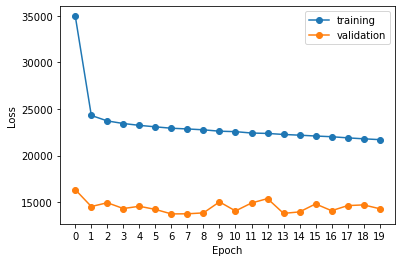

In [7]:
model_path = "./NeuralNets/Jacob/FFNN1/"

ffnn1 = build_model(lr=0.001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path + "{epoch:02d}-{val_loss:.3f}", 
                                                monitor='val_loss', 
                                                save_best_only=True,
                                                save_weights_only=False, 
                                                mode='max', verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = ffnn1.fit(
  x = lr_train_x,  
  y = lr_train_y,         
  epochs=20,             
  batch_size=64,
  #callbacks=[checkpoint, earlystopping],
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [8]:
# Load the best model
# files = os.listdir(model_path)
# paths = [os.path.join(model_path, basename) for basename in files if basename != "trainHistoryDict"]
# newestModelPath = max(paths, key=os.path.getctime)

# ffnn1 = tf.keras.models.load_model(newestModelPath)

# Evaluate
ffnn1_preds = ffnn1.predict(lr_test_x)
calculate_metrics("FFNN 1", lr_test_y, ffnn1_preds)

2022-07-11 20:14:15.479219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


FFNN 1 MAE: 47.571068383399826 kW.
FFNN 1 RMSE: 132.39492205759163 kW.


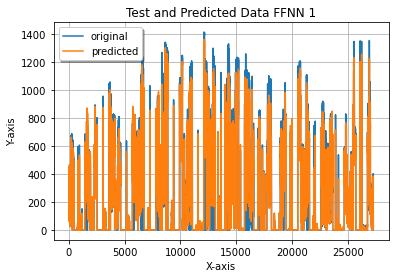

In [9]:
plot_true_vs_pred("FFNN 1", lr_test_y, ffnn1_preds)

# Results

In [36]:
model_results_df = pd.DataFrame([mae_results, rmse_results]).T
model_results_df.columns = ["MAE", "RMSE"]
model_results_df.sort_values(by='MAE', ascending=True)

,MAE,RMSE
Random Forest,38.286710,125.552449
Decision Tree 1,38.641552,125.113496
Gradient Boosting,42.374103,123.332359
FFNN 1,48.658158,136.641319
Linear Regression 1,78.700720,138.339576
Linear Regression Ridge,78.937520,138.372288
Linear Regression Lasso,79.032171,138.445598
Baseline,289.374273,329.970797


[CV 1/5] END max_depth=1;, score=(train=-47623.313, test=-39146.522) total time=   0.1s
[CV 1/5] END max_depth=3;, score=(train=-30326.462, test=-26526.618) total time=   0.1s
[CV 1/5] END max_depth=5;, score=(train=-26189.813, test=-22716.867) total time=   0.2s
[CV 2/5] END max_depth=7;, score=(train=-21315.422, test=-34571.297) total time=   0.2s
[CV 2/5] END max_depth=9;, score=(train=-19740.674, test=-35677.797) total time=   0.2s
[CV 1/5] END max_depth=11;, score=(train=-20908.267, test=-23765.443) total time=   0.3s
[CV 2/5] END max_depth=13;, score=(train=-16618.083, test=-38307.480) total time=   0.3s
[CV 1/5] END max_depth=15;, score=(train=-15944.697, test=-26528.497) total time=   0.3s
[CV 1/5] END max_depth=17;, score=(train=-13304.037, test=-28473.987) total time=   0.3s
[CV 2/5] END max_depth=19;, score=(train=-11943.579, test=-43672.596) total time=   0.3s
[CV 2/5] END max_depth=21;, score=(train=-10225.831, test=-46487.150) total time=   0.3s
[CV 5/5] END max_depth=22;

[CV 2/5] END max_depth=1;, score=(train=-42714.739, test=-59190.456) total time=   0.1s
[CV 3/5] END max_depth=3;, score=(train=-30680.020, test=-25001.569) total time=   0.1s
[CV 2/5] END max_depth=5;, score=(train=-23077.859, test=-35529.474) total time=   0.2s
[CV 1/5] END max_depth=7;, score=(train=-24414.251, test=-22434.027) total time=   0.2s
[CV 1/5] END max_depth=9;, score=(train=-22849.023, test=-22574.635) total time=   0.2s
[CV 2/5] END max_depth=11;, score=(train=-18191.867, test=-37062.770) total time=   0.3s
[CV 1/5] END max_depth=13;, score=(train=-18512.684, test=-25490.710) total time=   0.3s
[CV 5/5] END max_depth=14;, score=(train=-16895.076, test=-30669.813) total time=   0.3s
[CV 2/5] END max_depth=17;, score=(train=-13530.410, test=-41299.241) total time=   0.3s
[CV 1/5] END max_depth=19;, score=(train=-10634.878, test=-30091.520) total time=   0.3s
[CV 5/5] END max_depth=20;, score=(train=-11830.951, test=-33582.893) total time=   0.4s
[CV 1/5] END max_depth=23;

[CV 4/5] END max_depth=1;, score=(train=-47547.416, test=-39606.826) total time=   0.1s
[CV 5/5] END max_depth=3;, score=(train=-28121.831, test=-35668.747) total time=   0.1s
[CV 3/5] END max_depth=5;, score=(train=-26555.329, test=-21386.035) total time=   0.2s
[CV 3/5] END max_depth=7;, score=(train=-24419.804, test=-22348.043) total time=   0.2s
[CV 3/5] END max_depth=9;, score=(train=-22520.695, test=-23673.798) total time=   0.3s
[CV 4/5] END max_depth=11;, score=(train=-21817.557, test=-19642.666) total time=   0.3s
[CV 3/5] END max_depth=13;, score=(train=-18445.683, test=-27510.873) total time=   0.3s
[CV 3/5] END max_depth=15;, score=(train=-15991.067, test=-29572.657) total time=   0.3s
[CV 3/5] END max_depth=17;, score=(train=-13738.876, test=-30674.080) total time=   0.3s
[CV 3/5] END max_depth=19;, score=(train=-11514.083, test=-32930.212) total time=   0.3s
[CV 3/5] END max_depth=21;, score=(train=-9247.753, test=-34216.315) total time=   0.4s
[CV 3/5] END max_depth=23;,